### Import librabries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install Keras-Applications


In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm.notebook import tqdm

from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
import keras
from keras.layers import Dense, Conv2D, Activation,BatchNormalization, MaxPooling2D, Dropout, Flatten, Input
from keras.models import load_model, Sequential
from keras.layers.advanced_activations import LeakyReLU

#import cv2

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4448246182576357304
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15424759104324018601
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


### 1. Read the dataset

#### 1.2 Read labels

In [ ]:
# read labels
df_labels = pd.read_csv('/content/drive/MyDrive/data/Brain/dataset/dataset/label.csv')

In [ ]:
df_labels.head(10)

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor
5,IMAGE_0005.jpg,meningioma_tumor
6,IMAGE_0006.jpg,no_tumor
7,IMAGE_0007.jpg,glioma_tumor
8,IMAGE_0008.jpg,glioma_tumor
9,IMAGE_0009.jpg,pituitary_tumor


In [ ]:
df_labels.count()

file_name    3000
label        3000
dtype: int64

In [ ]:
df_labels['tumor'] = 1
df_labels['tumor'][df_labels['label'] == 'no_tumor'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


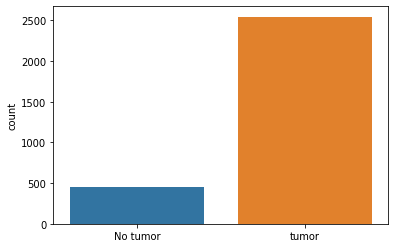

In [ ]:
plt.figure()
# To change the color visit: https://seaborn.pydata.org/tutorial/color_palettes.html?highlight=color 
sns.color_palette("muted")  
sns.countplot(x='tumor',  data=df_labels)
plt.xticks([0,1], ['No tumor', 'tumor'])
plt.xlabel("")
plt.show()

In [ ]:
df_labels['tumor_type'] = df_labels['tumor']
df_labels['tumor_type'] = df_labels['label'].map({'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3 })

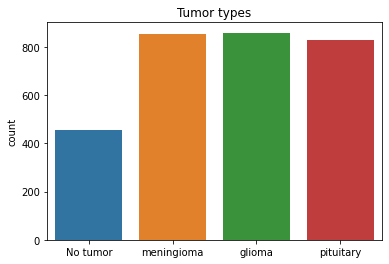

In [ ]:
plt.figure()
sns.countplot(x='tumor_type',  data=df_labels)
plt.xticks([0,1,2,3], ['No tumor', 'meningioma','glioma', 'pituitary'])
plt.xlabel("")
plt.title("Tumor types")
plt.show()

In [ ]:
df_labels.to_csv('p_labels.csv')

#### 2.2 Read images

In [ ]:
df_labels.head()

,file_name,label,tumor,tumor_type
0,IMAGE_0000.jpg,meningioma_tumor,1,1
1,IMAGE_0001.jpg,no_tumor,0,0
2,IMAGE_0002.jpg,meningioma_tumor,1,1
3,IMAGE_0003.jpg,glioma_tumor,1,2
4,IMAGE_0004.jpg,meningioma_tumor,1,1


In [ ]:
Img_id = df_labels['file_name']

In [ ]:
# "grayscale" for baseline models  "rgb" for cnn

imgs =[np.array(image.load_img('/content/drive/MyDrive/data/Brain/dataset/dataset/image/{}'.format(i),target_size=(100,100), color_mode = "rgb"))/255 for i in tqdm(Img_id[:Img_id.size])]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
imgs_arr = np.array(imgs)

In [ ]:
imgs_arr.shape

(3000, 100, 100, 3)

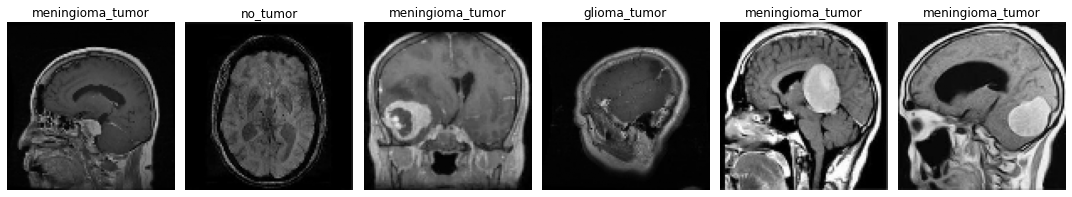

In [ ]:
# show samples
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(imgs_arr[i],cmap='gray')
    plt.title(df_labels.label[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
# for grayscale only
imgs_arr = imgs_arr.reshape(imgs_arr.shape[0], imgs_arr.shape[1], imgs_arr.shape[2], 1)

ValueError: ignored

In [ ]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(imgs_arr, df_labels.tumor, test_size=0.2, random_state=42, stratify=df_labels.tumor)

### 2. Baseline models

In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))

#### 2.1 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with 7 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the training data
with tf.device('/gpu:0'):
  knn.fit(X_train_reshaped, y_train)

In [ ]:
# Print the accuracy
print("Training accuracy: ", knn.score(X_train_reshaped, y_train))

Training accuracy:  0.9383333333333334


In [ ]:
print("Test accuracy: ", knn.score(X_test_reshaped, y_test))

Test accuracy:  0.9116666666666666


In [ ]:
y_pred = knn.predict(X_test_reshaped)
target_names = ['No tumor', 'Tumor']
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    No tumor     0.7209    0.6813    0.7006        91
       Tumor     0.9436    0.9528    0.9482       509

    accuracy                         0.9117       600
   macro avg     0.8323    0.8171    0.8244       600
weighted avg     0.9098    0.9117    0.9106       600



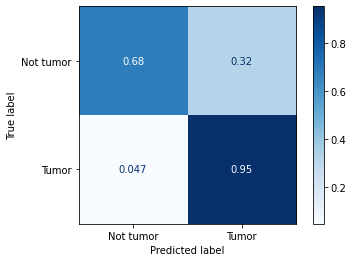

In [ ]:
plot_confusion_matrix(knn, X_test_reshaped, y_test, normalize = "true", cmap=plt.cm.Blues, display_labels=['Not tumor', 'Tumor'])  
plt.show()

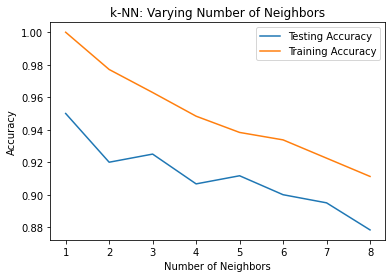

In [ ]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    with tf.device('/gpu:0'):
      knn.fit(X_train_reshaped, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train_reshaped, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test_reshaped, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

####2.2 SVM

In [ ]:
# SVM
from sklearn.svm import SVC

# Instantiate the SVC classifier: clf
clf = SVC()

# Fit the pipeline to the train set
with tf.device('/gpu:0'):
  clf.fit(X_train_reshaped, y_train)

In [ ]:
# Print the accuracy
print("Training accuracy: ", knn.score(X_train_reshaped, y_train))

Training accuracy:  0.91125


In [ ]:
print("Test accuracy: ", knn.score(X_test_reshaped, y_test))

Test accuracy:  0.8783333333333333


In [ ]:
# Predict the labels of the test set
y_pred = clf.predict(X_test_reshaped)

# Compute metrics
target_names = ['No tumor', 'Tumor']
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    No tumor     0.8667    0.5714    0.6887        91
       Tumor     0.9278    0.9843    0.9552       509

    accuracy                         0.9217       600
   macro avg     0.8972    0.7779    0.8220       600
weighted avg     0.9185    0.9217    0.9148       600



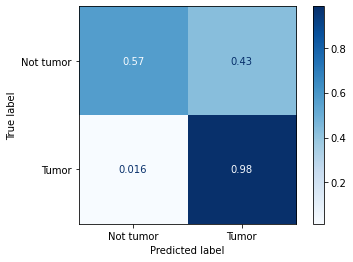

In [ ]:
# normalized
plot_confusion_matrix(clf, X_test_reshaped, y_test, normalize = "true", cmap=plt.cm.Blues, display_labels=['Not tumor', 'Tumor'])  
plt.show()

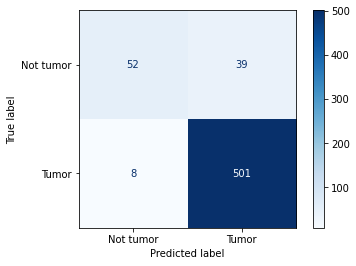

In [ ]:
plot_confusion_matrix(clf, X_test_reshaped, y_test, cmap=plt.cm.Blues, values_format=".0f", display_labels=['Not tumor', 'Tumor'])  
plt.show()

### 3. Main model

In [ ]:
# Things to do:  1. Cross validation

# cross-validation

from sklearn.model_selection import cross_val_score

cv_results = cross_val_score(reg, X, y, cv=5)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))


#### 3.1 Handling data imbalance (class weights)

##### CNN ( good)

In [ ]:
## CNN 

model = Sequential()
model.add(Conv2D(64, (5,5), input_shape = (X_train[0].shape[0], X_train[0].shape[1], 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size =  (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size =  (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), padding = 'same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size =  (2,2)))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_194 (Conv2D)         (None, 100, 100, 64)      4864      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 100, 100, 64)      0         
                                                                 
 batch_normalization_210 (Ba  (None, 100, 100, 64)     256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_195 (Conv2D)         (None, 50, 50, 128)      

In [ ]:
# Compile the model
model.compile(loss=keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='adam')

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

computed_class_weights = dict(enumerate(class_weights))


In [ ]:
# Create training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [ ]:
# Fit the model
with tf.device('/gpu:0'):
  history = model.fit(X_train, y_train,
                    epochs = 30,
                    batch_size = 100,
                    validation_data=(X_val,y_val),
                    #class_weight = computed_class_weights,
                    verbose=1)

Epoch 1/30
9/9 [==============================] - 1s 63ms/step - loss: 0.0097 - accuracy: 0.9988 - val_loss: 0.3742 - val_accuracy: 0.9462
Epoch 2/30
9/9 [==============================] - 1s 59ms/step - loss: 0.0092 - accuracy: 0.9988 - val_loss: 0.3715 - val_accuracy: 0.9462
Epoch 3/30
9/9 [==============================] - 1s 59ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.3166 - val_accuracy: 0.9355
Epoch 4/30
9/9 [==============================] - 1s 60ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.3201 - val_accuracy: 0.9462
Epoch 5/30
9/9 [==============================] - 1s 59ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.3793 - val_accuracy: 0.9462
Epoch 6/30
9/9 [==============================] - 1s 58ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3488 - val_accuracy: 0.9462
Epoch 7/30
9/9 [==============================] - 1s 59ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.3347 - val_accuracy: 0.9355
Epoch 8/30
9/9 [===========

Results with class weights:
Epoch 1/5
24/24 [==============================] - 301s 13s/step - loss: 0.6441 - accuracy: 0.7638 - val_loss: 0.3410 - val_accuracy: 0.8567

Epoch 2/5
24/24 [==============================] - 303s 13s/step - loss: 0.3454 - accuracy: 0.8483 - val_loss: 0.4639 - val_accuracy: 0.8483

Epoch 3/5
24/24 [==============================] - 295s 12s/step - loss: 0.2820 - accuracy: 0.8892 - val_loss: 0.4256 - val_accuracy: 0.8483

Epoch 4/5
24/24 [==============================] - 302s 13s/step - loss: 0.2352 - accuracy: 0.9112 - val_loss: 0.5433 - val_accuracy: 0.8483

Epoch 5/5
24/24 [==============================] - 298s 12s/step - loss: 0.2024 - accuracy: 0.9137 - val_loss: 0.4604 - val_accuracy: 0.8483

In [ ]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


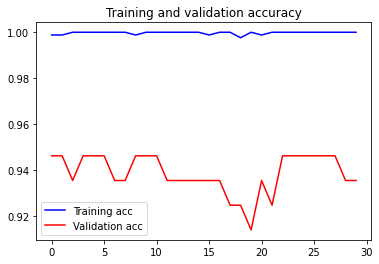

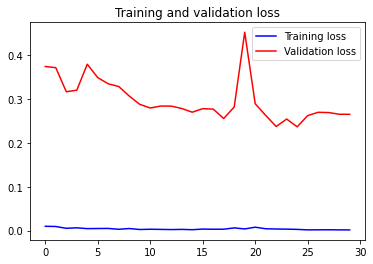

In [ ]:
# Run the function to illustrate accuracy and loss
visualize_results(history)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
target_names = ['No tumor', 'Tumor']
print(classification_report(y_test, y_pred.round(), target_names=target_names, digits=4))

              precision    recall  f1-score   support

    No tumor     0.8406    0.6374    0.7250        91
       Tumor     0.9379    0.9784    0.9577       509

    accuracy                         0.9267       600
   macro avg     0.8892    0.8079    0.8413       600
weighted avg     0.9231    0.9267    0.9224       600



In [ ]:
# Not Normalized
cm = confusion_matrix(y_test, y_pred.round())
print(cm)

[[ 58  33]
 [ 11 498]]


In [ ]:
# Normalized
cm = confusion_matrix(y_test, y_pred.round(), normalize='true')
print(cm)

[[0.63736264 0.36263736]
 [0.021611   0.978389  ]]


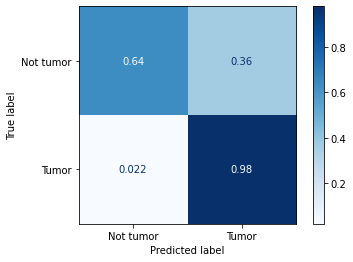

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not tumor', 'Tumor'])
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

##### Fine-tuning

In [ ]:
from keras.models import Model

#from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications import ResNet50


# load model and specify a new input shape for images
input_tensor = Input(shape=(100, 100, 3))

# creating the base model of pre-trained VGG16 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [ ]:
# Freeze all the layers
for layer in base_model.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f962d5e3a50> False
<keras.layers.convolutional.Conv2D object at 0x7f962d5e38d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f96f1c742d0> False
<keras.layers.core.activation.Activation object at 0x7f96f2156fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f96f2134c90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f962c01add0> False
<keras.layers.core.activation.Activation object at 0x7f96f1c885d0> False
<keras.layers.convolutional.Conv2D object at 0x7f96f1c5c290> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f96f1c5cf50> False
<keras.layers.core.activation.Activation object at 0x7f96f1c5e210> False
<keras.layers.pooling.MaxPooling2D object at 0x7f962c0075d0> False
<keras.layers.convolutional.Conv2D object at 0x7f962c007850> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7

In [ ]:
# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))

model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_33 (Dense)            (None, 256)               524544    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_312 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                     

In [ ]:
# defining a function to save the weights of best model
#from keras.callbacks import ModelCheckpoint
#mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# Compile the model
model.compile(loss=keras.losses.binary_crossentropy, metrics=['accuracy'], optimizer='adam')

In [ ]:
# Create training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

computed_class_weights = dict(enumerate(class_weights))


In [ ]:
computed_class_weights

{0: 3.25, 1: 0.5909090909090909}

In [ ]:
# Fit the model

history = model.fit(X_train, y_train,
                    epochs = 30,
                    batch_size = 100,
                    validation_data=(X_val,y_val),
                    class_weight= computed_class_weights)

Epoch 1/30
6/6 [==============================] - 6s 419ms/step - loss: 0.0362 - accuracy: 0.9908 - val_loss: 0.0343 - val_accuracy: 1.0000
Epoch 2/30
6/6 [==============================] - 0s 43ms/step - loss: 0.0242 - accuracy: 0.9945 - val_loss: 0.0196 - val_accuracy: 0.9836
Epoch 3/30
6/6 [==============================] - 0s 43ms/step - loss: 0.0333 - accuracy: 0.9908 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 4/30
6/6 [==============================] - 0s 50ms/step - loss: 0.0397 - accuracy: 0.9780 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 5/30
6/6 [==============================] - 0s 43ms/step - loss: 0.0266 - accuracy: 0.9853 - val_loss: 0.0141 - val_accuracy: 0.9836
Epoch 6/30
6/6 [==============================] - 0s 42ms/step - loss: 0.0247 - accuracy: 0.9963 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 7/30
6/6 [==============================] - 0s 43ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 0.9836
Epoch 8/30
6/6 [==========

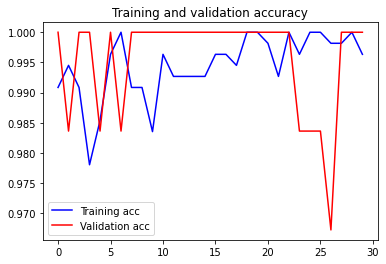

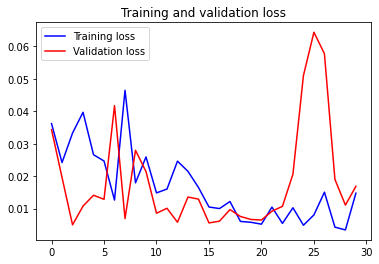

In [ ]:
# Run the function to illustrate accuracy and loss
visualize_results(history)

In [ ]:
y_pred = model.predict(X_test)
target_names = ['No tumor', 'Tumor']
print(classification_report(y_test, y_pred.round(), target_names=target_names, digits=4))

              precision    recall  f1-score   support

    No tumor     0.8406    0.6374    0.7250        91
       Tumor     0.9379    0.9784    0.9577       509

    accuracy                         0.9267       600
   macro avg     0.8892    0.8079    0.8413       600
weighted avg     0.9231    0.9267    0.9224       600



In [ ]:
# Not Normalized
cm = confusion_matrix(y_test, y_pred.round())
print(cm)

[[ 58  33]
 [ 11 498]]


In [ ]:
# Normalized
cm = confusion_matrix(y_test, y_pred.round(), normalize='true')
print(cm)

[[0.63736264 0.36263736]
 [0.021611   0.978389  ]]


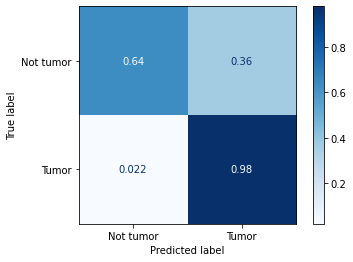

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not tumor', 'Tumor'])
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

##### Fine-tuning with data augmentation

In [ ]:
# Train images
x_train = []
for i in tqdm(train_x):
    image_path = '/content/drive/MyDrive/data/Brain/dataset/dataset/image/'+i
    img = np.array(image.load_img(image_path, target_size=(100,100), color_mode = "rgb"), dtype="float")/ 255.0
    x_train.append(img)

  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
# Train df
df_train = pd.DataFrame(columns=['file_name','tumor'])
df_train['file_name'] = train_x
df_train['tumor'] = train_y

# Test df
df_test= pd.DataFrame(columns=['file_name','tumor'])
df_test['file_name'] = val_x
df_test['tumor'] = val_y

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
# Images
train_images = df_train.loc[:,'file_name']
train_labels = df_train.loc[:,'tumor']

test_images = df_test.loc[:,'file_name']
test_labels = df_test.loc[:,'tumor']

# Train images
x_train = []
for i in tqdm(train_images):
    image_path = '/content/drive/MyDrive/data/Brain/dataset/dataset/image/'+i
    img = np.array(image.load_img(image_path, target_size=(100,100), color_mode = "rgb"), dtype="float")/ 255.0
    x_train.append(img)

# Train labels
#y_train=keras.utils.np_utils.to_categorical(train_labels)

  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
# Test images
x_test = []
for i in tqdm(test_images):
    image_path = '/content/drive/MyDrive/data/Brain/dataset/dataset/image/'+i
    img = np.array(image.load_img(image_path, target_size=(100,100), color_mode = "rgb"), dtype="float")/ 255.0
    x_test.append(img)

# Test labels
#y_test=keras.utils.np_utils.to_categorical(test_labels)



  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [ ]:
#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [ ]:
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
from keras.models import Model

from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet50 import ResNet50

# load model and specify a new input shape for images
input_tensor = Input(shape=(100, 100, 3))

# creating the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze all the layers
for layer in base_model.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd65945d5d0> False
<keras.layers.convolutional.Conv2D object at 0x7fd657071350> False
<keras.layers.convolutional.Conv2D object at 0x7fd6570194d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd659452c10> False
<keras.layers.convolutional.Conv2D object at 0x7fd656f02e90> False
<keras.layers.convolutional.Conv2D object at 0x7fd65701ed10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd656f33650> False
<keras.layers.convolutional.Conv2D object at 0x7fd65701ecd0> False
<keras.layers.convolutional.Conv2D object at 0x7fd6570251d0> False
<keras.layers.convolutional.Conv2D object at 0x7fd66122c150> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd661224250> False
<keras.layers.convolutional.Conv2D object at 0x7fd656f39dd0> False
<keras.layers.convolutional.Conv2D object at 0x7fd656f08f90> False
<keras.layers.convolutional.Conv2D object at 0x7fd65982bad0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd65953cd50>

In [ ]:
# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))

model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1179904   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_y)
                                               ,train_y)

computed_class_weights = dict(enumerate(class_weights))


In [ ]:
df_train.head()

Found 2400 validated image filenames belonging to 2 classes.


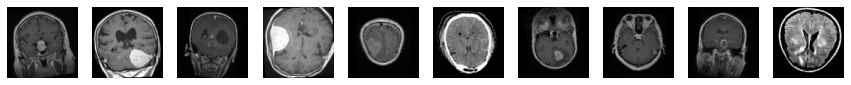

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Augmentation
train_datagen = ImageDataGenerator(rotation_range=10,  # rotation
                                   #width_shift_range=0.1,  # horizontal shift
                                   # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   vertical_flip=True,
                                   fill_mode="constant"
                                   #brightness_range=[0.2,0.5]
                                   )  # brightness

# ImageDataGenerator flow_from_dataframe

#df_train = pd.read_csv('/content/drive/MyDrive/data/Brain/dataset/dataset/label.csv')
df_train['tumor'] = df_train['tumor'].astype('str')

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train, 
                                              directory='/content/drive/MyDrive/data/Brain/dataset/dataset/image',
                                              x_col="file_name", 
                                              y_col="tumor",                          
                                              class_mode="binary", 
                                              target_size=(100, 100), 
                                              batch_size=1,
                                              rescale=1.0/255,
                                              seed=2020)
# plotting images
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(10):

  # convert to unsigned integers for plotting
  img = next(train_generator)[0].astype('uint8')

  # changing size from (1, 100, 100, 3) to (100, 100, 3) for plotting the image
  img = np.squeeze(img)

  # plot raw pixel data
  ax[i].imshow(img)
  ax[i].axis('off')

In [ ]:
valid_datagen = ImageDataGenerator(rotation_range=20,  # rotation
                                   #width_shift_range=0.1,  # horizontal shift
                                    # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   vertical_flip=True,
                                   fill_mode="constant"
                                   #brightness_range=[0.2,0.5]
                                   )  # brightness

valid_generator = valid_datagen.flow_from_dataframe(dataframe=df_test, 
                                                    directory='/content/drive/MyDrive/data/Brain/dataset/dataset/image',
                                                    x_col="file_name", 
                                                    y_col="tumor", 
                                                    class_mode="binary", 
                                                    target_size=(100, 100), 
                                                    batch_size=1,
                                                    rescale=1.0/255,
                                                    seed=2020)

In [ ]:
# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Epochs
epochs = 10
# Batch size
batch_size = 100

history = model.fit(train_generator,
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=valid_generator,
                    class_weight = computed_class_weights,
                    verbose=1)

In [ ]:
# Run the function to illustrate accuracy and loss
visualize_results(history)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred.round()))

In [ ]:
print(confusion_matrix(y_test, y_pred.round()))

In [ ]:
model.save("tumor_classification.h5")
print("Saved model to disk")